In [1]:
from basic import processing
import os
import pandas as pd
from pyswarm import pso
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt 
import numpy as np
import operator
from osgeo import gdal, gdal_array,osr
import shapefile
import xgboost as xgb
import pickle

In [7]:
def get_filename(path,filetype):  # 输入路径、文件类型 例如'.csv'
    name = []
    for root,dirs,files in os.walk(path):
        for i in files:
            if filetype+' ' in i+' ':    # 这里后面不加一个字母可能会出问题，加上一个（不一定是空格）可以解决99.99%的情况
                name.append(i)    
    return name            # 输出由有后缀的文件名组成的列表


In [35]:
def doc_RS(path,model_file):
    
    from time import time
    import datetime

    time0 = time()
    
    os.chdir(path) # 切换文件夹，将原始影像，生成影像，模型放在该文件夹下
    img_input_file = get_filename(model_path,'sh.dat')
    img_output_file=['DOC_'+img_input_file[i] for i in range(len(img_input_file))]
    
    for i in range(len(img_input_file)):

        proj,geotrans,data =processing.read_img(img_input_file[i])        #读影像数据


        # 读入影像数据到llist
        img_data_read = np.concatenate([data[j].reshape(-1,1) for j in range(data.shape[0])],
                                   axis=1)
        img_data_read= pd.DataFrame(img_data_read).iloc[:,:7]


        img_data_read[np.isinf(img_data_read)]=0 # 去除极大值
        np.isinf(img_data_read).sum() 

        #img_data_imput = processing.data_preprocessing(img_data_read) # 影像数据标准化
        img_data_imput = img_data_read

        if model_file =='xgboost_cdom.dat':
            img_data_imput = xgb.DMatrix(img_data_imput) #xgb模型需要特殊的数据格式

        #导入模型

        loaded_model = pickle.load(open(model_file, "rb"))
        if i==0:
            print("Loaded model from: %s" %(model_file))

        img_result = loaded_model.predict(img_data_imput) #做预测

        img_cdom = np.reshape(img_result,(data.shape[1],data.shape[2])) # 将预测结果还原

        processing.write_img(img_output_file[i],proj,geotrans,img_cdom) #导出影像
        print("Finish file output : %s" %(img_output_file[i]))
        
    time= datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f") #计算时间戳并转换为时分秒
    return time

In [36]:
model_path = r'F:\lastpaper\data\L8_year\L8flaash' # 输入文件所在路径
model_file = "xgboost_cdom.dat"
# img_input_file = get_filename(model_path,'sh.dat')
# img_output_file=['DOC_'+img_input_file[i] for i in range(len(img_input_file))]

# img_output_file
doc_RS(model_path,model_file)

Loaded model from: xgboost_cdom.dat
Finish file output : DOC_L8_20131026_ref_flaash.dat
Finish file output : DOC_L8_20140904_ref_flassh.dat
Finish file output : DOC_L8_20150930_ref_flassh.dat
Finish file output : DOC_L8_20161011_ref_flassh.dat
Finish file output : DOC_L8_20170912_ref_flaash.dat
Finish file output : DOC_L8_20180906_ref_flaash.dat
Finish file output : DOC_L8_20190909_ref_flaash.dat
Finish file output : DOC_L8_20200131_ref_flassh.dat
Finish file output : DOC_L8_20200328_ref_flaash.dat
Finish file output : DOC_L8_20200718_ref_flaash.dat
Finish file output : DOC_L8_20201107_ref_flaash.dat


'00:02:635829'

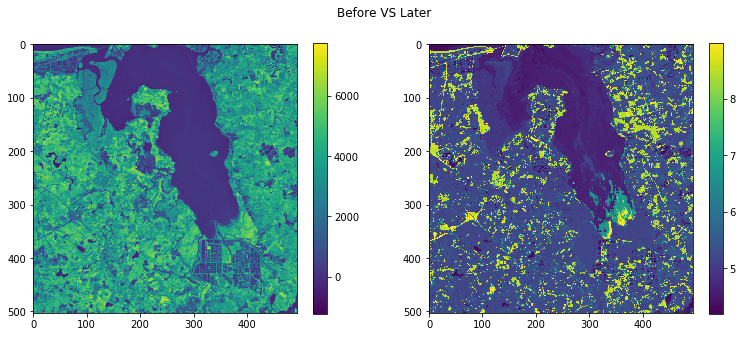

In [29]:
# 绘图
plt.figure(1, figsize=(13, 5))
 
plt.subplot(121)
plt.imshow(data[4])
plt.colorbar()
plt.subplot(122)
plt.imshow(img_cdom[:,:])
plt.colorbar()
plt.suptitle('Before VS Later')
plt.show()